<a href="https://colab.research.google.com/github/TonioHathos/AI_Valeo/blob/main/code_Antoine/Mod%C3%A8le_NN_Antoine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-25 17:03:40--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0s      

2023-05-25 17:03:40 (105 MB/s) - ‘visualization.py’ saved [13023/13023]



### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [6]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'TSP/Apprentissage_automatique_réseau/'

Mounted at /content/gdrive


## Récupérer dataset modifié

In [7]:
! rm -f *.csv
! wget https://raw.githubusercontent.com/TonioHathos/AI_Valeo/master/df_training_mod.csv
df_training_mod = pd.read_csv('df_training_mod.csv')

--2023-05-25 17:04:00--  https://raw.githubusercontent.com/TonioHathos/AI_Valeo/master/df_training_mod.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2666373 (2.5M) [text/plain]
Saving to: ‘df_training_mod.csv’

df_training_mod.csv 100%[===================>]   2.54M  --.-KB/s    in 0.09s   

2023-05-25 17:04:00 (27.0 MB/s) - ‘df_training_mod.csv’ saved [2666373/2666373]



In [8]:
df_training_mod.columns

Index(['Unnamed: 0', 'OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value',
       'Binar OP130_Resultat_Global_v'],
      dtype='object')

In [9]:
labels_raw = df_training_mod['Binar OP130_Resultat_Global_v'].copy()
df_training_mod = df_training_mod.drop(columns=['Unnamed: 0', 'Binar OP130_Resultat_Global_v'])

### Class imbalance

In [10]:
labels_raw

0        0
1        0
2        0
3        0
4        0
        ..
34510    0
34511    0
34512    0
34513    0
34514    0
Name: Binar OP130_Resultat_Global_v, Length: 34515, dtype: int64

In [11]:
df_training_mod

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
0,180.4,190.51,173.1,113.64,12.04,12.16,0.0,11.97,26.37,18.8,109.62,6.60
1,138.7,147.70,163.5,109.77,12.12,12.19,1.0,11.97,21.03,18.5,105.48,6.40
2,180.9,150.87,181.2,109.79,11.86,12.24,0.0,11.97,25.81,17.5,100.03,6.61
3,173.5,159.56,151.8,113.25,11.82,12.35,1.0,11.97,24.62,15.6,104.94,6.61
4,174.5,172.29,177.5,112.88,12.07,12.19,0.0,11.97,29.22,33.6,99.19,6.61
...,...,...,...,...,...,...,...,...,...,...,...,...
34510,158.2,168.40,180.6,110.65,11.88,12.23,0.0,11.98,24.03,14.8,98.76,6.61
34511,139.4,146.24,154.5,108.14,12.04,12.27,1.0,11.97,21.52,15.5,98.37,6.40
34512,165.5,157.34,149.8,112.77,12.09,12.17,0.0,11.97,22.65,24.4,92.92,6.62
34513,152.4,165.07,140.0,111.19,12.06,12.34,0.0,11.97,20.77,13.6,101.21,6.60


In [12]:
Counter(labels_raw)

Counter({0: 34210, 1: 305})

On va corriger ce déséquilibre en applicant la fonction SMOTE()

In [13]:
smote = SMOTE()
df_training, labels = smote.fit_resample(df_training_mod, labels_raw)

In [14]:
Counter(labels)

Counter({0: 34210, 1: 34210})

### Scaling

In [15]:
scaler = StandardScaler()
scaler.fit(df_training)

df_training = scaler.transform(df_training)

In [16]:
print('X_train scaled\n', df_training[0:6, :] )

X_train scaled
 [[ 1.44056362  3.12350727  0.96057509  0.06956692  0.4134089  -1.64289269
  -1.16398293 -0.33050421  1.10238772  0.14071387  1.84235946  0.7284248 ]
 [-1.35316394 -0.8025515   0.29958791 -1.16197594  0.99716983 -1.1297349
   0.94534486 -0.33050421 -1.17054505  0.09410877  1.17228779 -1.38453748]
 [ 1.47406155 -0.51183423  1.51828301 -1.15561137 -0.90005322 -0.27447193
  -1.16398293 -0.33050421  0.86402773 -0.06124157  0.29018862  0.83407292]
 [ 0.97829215  0.28511626 -0.5059902  -0.05454205 -1.19193369  1.60710663
   0.94534486 -0.33050421  0.35751275 -0.35640722  1.08488714  0.83407292]
 [ 1.04528802  1.45257079  1.26352754 -0.17228646  0.63231925 -1.1297349
  -1.16398293 -0.33050421  2.31546982  2.43989891  0.15423205  0.83407292]
 [-0.01324664  0.85646282  1.32549509 -0.42368668 -0.75411298 -1.81394529
  -1.16398293 -0.33050421  0.94064345  0.68444006 -0.17918525  1.04536914]]


In [17]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
68415    1
68416    1
68417    1
68418    1
68419    1
Name: Binar OP130_Resultat_Global_v, Length: 68420, dtype: int64

## Création de notre modèle de réseaux de neurones

In [23]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="sigmoid",
                          loss_fun="binary_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate) ,
              metrics=metrics)
  
  return model

As en example, let us instantiate our first neural network

In [20]:
df_training.shape[1]

12

In [21]:
sample_size = df_training.shape[1]

In [27]:
shallow_architecture = [8, 6, 1]
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.1)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 104       
                                                                 
 dense_13 (Dense)            (None, 6)                 54        
                                                                 
 dense_14 (Dense)            (None, 1)                 7         
                                                                 
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


Let's introduce some operations to make our code **repeatable**: we want to have the same results, every time we run the different neural networks below, no matter the order in which we run them and no matter who runs them.

 To this aim, we use the following tricks:
 * `clear_session()`: it resets the neural network weights. If we do not do so, if we train a certain neural network A and then another neural network B, which may have the same architecture, some of the weights of B are initialized as in A. If we run in the opposite order, some of the weights of A are initialized as in B. Therefore, our results would depend on the order of training, which we do not want. This is why we will use `clear_session`. Actually, this function does even more: it resets all the variables handled by tensorflow. If you do not use it, every time you create a new neural network tensor flow will not remove the previous ones and adds the new one to its set of variables. This can bring to an excessive memory consumption. `clear_session` resets everything, thus solving memory problems.
 * Setting seeds: during training, there is some stochastic operations done: for instance, the validation set is chosen randomly, by default, the batch of samples is selected randomly at each iteration, etc.

More on randomness and reproducibility, on [this ODSC's blog](https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752). 

In [28]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

## Training

In [29]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=False, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=validation_split )

  return history

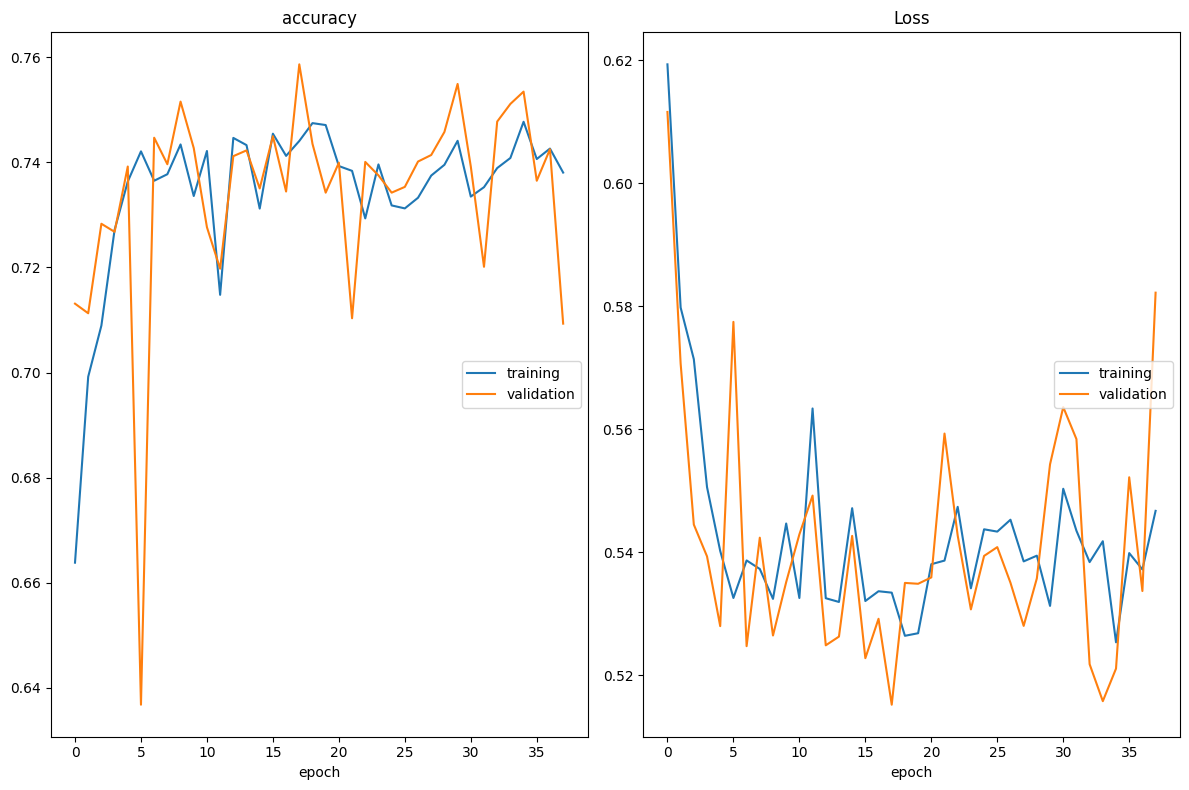

accuracy
	training         	 (min:    0.664, max:    0.748, cur:    0.738)
	validation       	 (min:    0.637, max:    0.759, cur:    0.709)
Loss
	training         	 (min:    0.525, max:    0.619, cur:    0.547)
	validation       	 (min:    0.515, max:    0.612, cur:    0.582)
Restoring model weights from the end of the best epoch: 18.
1711/1711 [==============================] - 8s 5ms/step - loss: 0.5467 - accuracy: 0.7380 - val_loss: 0.5822 - val_accuracy: 0.7093
Epoch 38: early stopping


In [30]:
nn_file = my_path + 'nn-0.1.s10'

history = train_model(model, nn_file, df_training, labels, seed=10, max_epochs=200)

On remarque que le taux d'apprentissage est trop élevé avec des sauts trop importants sur la loss: diminuons-le à 0.01

In [33]:
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.01)


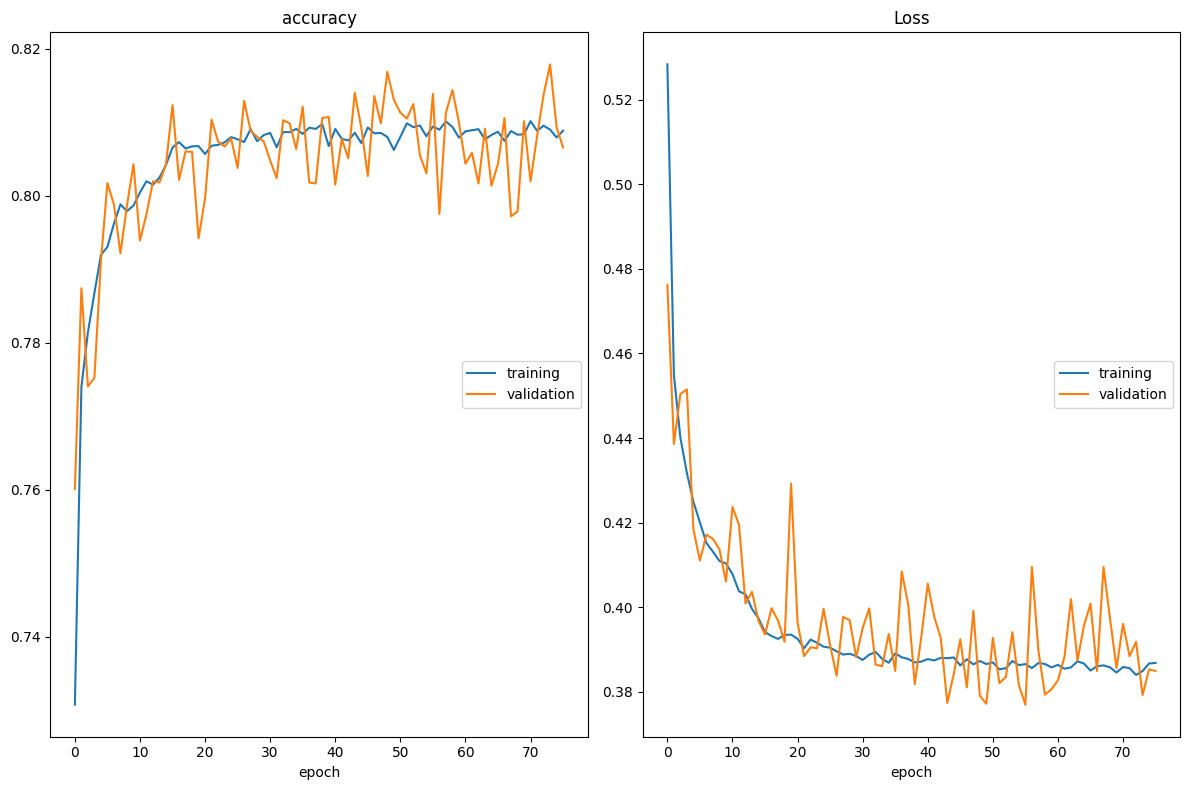

accuracy
	training         	 (min:    0.731, max:    0.810, cur:    0.809)
	validation       	 (min:    0.760, max:    0.818, cur:    0.807)
Loss
	training         	 (min:    0.384, max:    0.528, cur:    0.387)
	validation       	 (min:    0.377, max:    0.476, cur:    0.385)
Restoring model weights from the end of the best epoch: 56.
1711/1711 [==============================] - 8s 5ms/step - loss: 0.3868 - accuracy: 0.8089 - val_loss: 0.3849 - val_accuracy: 0.8066
Epoch 76: early stopping


In [34]:
nn_file = my_path + 'nn-0.2.s10'

history = train_model(model, nn_file, df_training, labels, seed=10, max_epochs=200)

La fluctuation est encore trop importante: on va changer le learning rate à 0.001

In [36]:
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.001)


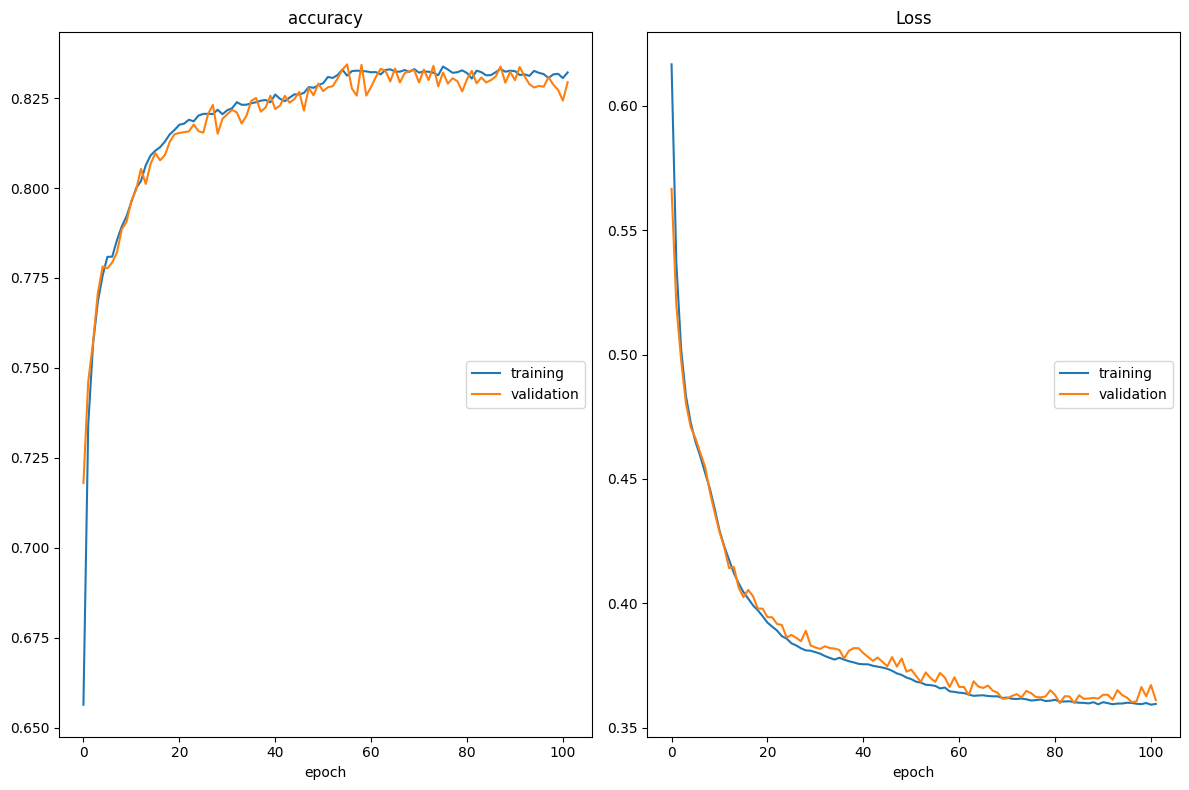

accuracy
	training         	 (min:    0.656, max:    0.834, cur:    0.832)
	validation       	 (min:    0.718, max:    0.834, cur:    0.829)
Loss
	training         	 (min:    0.359, max:    0.617, cur:    0.360)
	validation       	 (min:    0.360, max:    0.567, cur:    0.361)
Restoring model weights from the end of the best epoch: 82.
1711/1711 [==============================] - 8s 5ms/step - loss: 0.3596 - accuracy: 0.8322 - val_loss: 0.3611 - val_accuracy: 0.8294
Epoch 102: early stopping


In [37]:
nn_file = my_path + 'nn-0.3.s10'

history = train_model(model, nn_file, df_training, labels, seed=10, max_epochs=200)

Dernier essai avec un learning rate encore plus faible

In [38]:
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.0001)


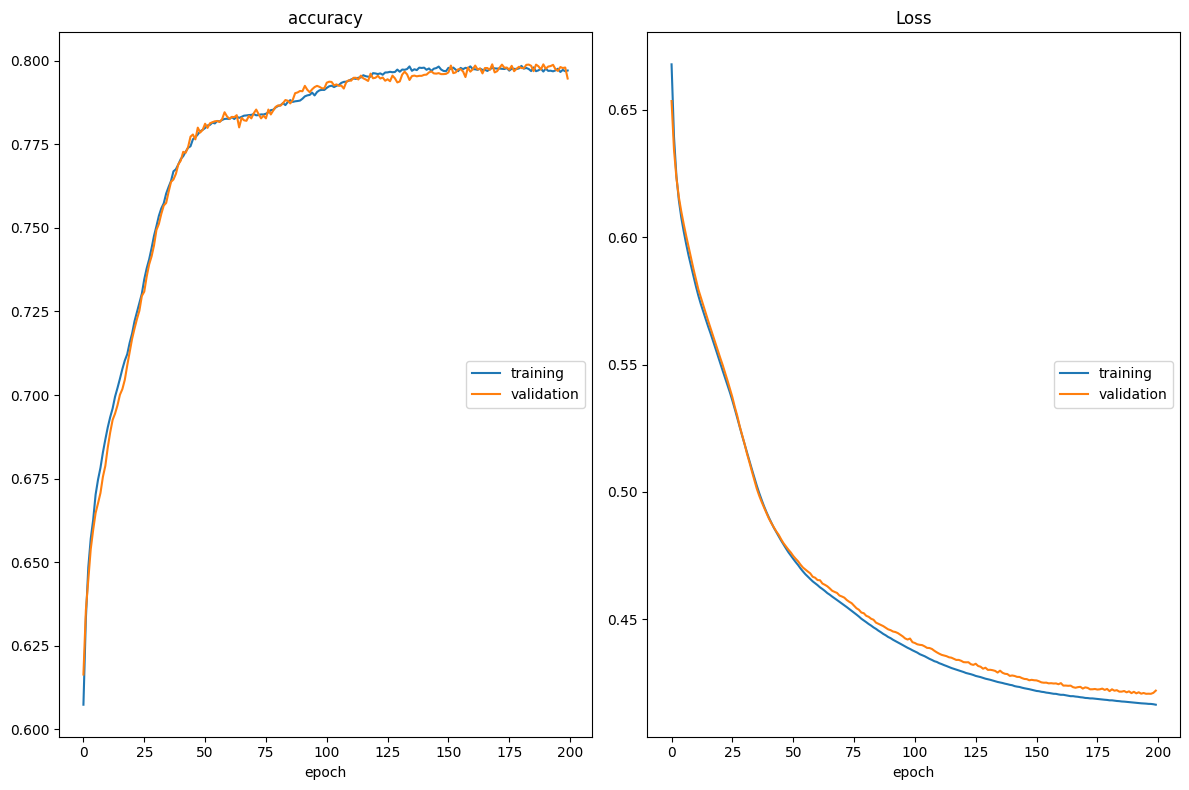

accuracy
	training         	 (min:    0.607, max:    0.798, cur:    0.797)
	validation       	 (min:    0.616, max:    0.799, cur:    0.795)
Loss
	training         	 (min:    0.416, max:    0.668, cur:    0.416)
	validation       	 (min:    0.421, max:    0.654, cur:    0.422)
1711/1711 [==============================] - 9s 5ms/step - loss: 0.4164 - accuracy: 0.7970 - val_loss: 0.4219 - val_accuracy: 0.7947


In [ ]:
nn_file = my_path + 'nn-0.4.s10'

history = train_model(model, nn_file, df_training, labels, seed=10, max_epochs=200)